ref:https://www.datacamp.com/community/tutorials/recommender-systems-python

In [1]:
# Import Pandas
import pandas as pd

# Load Movies Metadata
metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

# Print the first three rows
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


# Simple Recommender

Calculate a weighted rating:

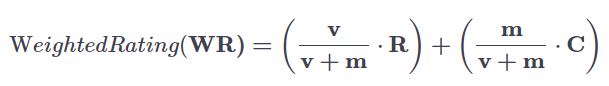

In the above equation,

* v is the number of votes for the movie;

* m is the minimum votes required to be listed in the chart;

* R is the average rating of the movie;

* C is the mean vote across the whole report.

In [2]:
# We have v and R already.
# Calculate mean of vote average column ("C"):
C = metadata['vote_average'].mean()
print(C)

5.618207215133889


In [3]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
print(m)

160.0


In [4]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

In [5]:
metadata.shape

(45466, 24)

In [6]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [7]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [8]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


# Content-Based Recommender

In [9]:
#Print plot overviews of the first 5 movies.
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [10]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(45466, 75827)

In [11]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[5000:5010]

['avails',
 'avaks',
 'avalanche',
 'avalanches',
 'avallone',
 'avalon',
 'avant',
 'avanthika',
 'avanti',
 'avaracious']

In [12]:
# From the above output, we observe that there are 75,827 different words in the dataset of 45,000 movies.

In [13]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [14]:
cosine_sim.shape

(45466, 45466)

In [ ]:
cosine_sim[1]

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

In [ ]:
indices[:10]

For the Content-Based recommender, the following function will:

* Get the index of the movie given its title.

* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position, and the second is the similarity score.

* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.

* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).

* Return the titles corresponding to the indices of the top elements

In [18]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    print(sim_scores[0:2])
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    print(sim_scores[0:2])
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    print(sim_scores[0:2])
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [19]:
get_recommendations('The Dark Knight Rises')

[(0, 0.0), (1, 0.005999880113302269)]
[(18252, 1.0), (12481, 0.3266388269758339)]
[(12481, 0.3266388269758339), (150, 0.31621098812584586)]


12481                                      The Dark Knight
150                                         Batman Forever
1328                                        Batman Returns
15511                           Batman: Under the Red Hood
585                                                 Batman
21194    Batman Unmasked: The Psychology of the Dark Kn...
9230                    Batman Beyond: Return of the Joker
18035                                     Batman: Year One
19792              Batman: The Dark Knight Returns, Part 1
3095                          Batman: Mask of the Phantasm
Name: title, dtype: object

### Credits, Genres, and Keywords Based Recommender

In [20]:
# Load keywords and credits
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

# Remove rows with bad IDs.
metadata = metadata.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [21]:
# Print the first two movies of your newly merged metadata. New columns are "cast", "crew", and "keywords".
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [22]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

In [23]:
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [24]:
# Import Numpy
import numpy as np

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [25]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [26]:
# Define new director, cast, genres and keywords features that are in a suitable form.
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [27]:
# Print the new features of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [28]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [29]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

The `create_soup` function will simply join all the required columns by a space. This is the final preprocessing step, and the output of this function will be fed into the word vector model.

In [30]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [31]:
# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

In [32]:
metadata[['soup']].head(2)

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...


In [33]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [34]:
count_matrix.shape

(46628, 73881)

In [35]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [36]:
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [37]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

[(0, 0.0), (1, 0.0)]
[(18442, 0.9999999999999999), (12589, 0.7999999999999999)]
[(12589, 0.7999999999999999), (10210, 0.7)]


12589      The Dark Knight
10210        Batman Begins
9311                Shiner
9874       Amongst Friends
7772              Mitchell
516      Romeo Is Bleeding
11463         The Prestige
24090            Quicksand
25038             Deadfall
41063                 Sara
Name: title, dtype: object